In [448]:
from os import makedirs  # Para crear directorios
from sys import argv  # Para acceder a los argumentos de la línea de comandos
from time import time  # Para medir el tiempo
from tomllib import load  # Para cargar datos específicos
import numpy as np  # Para operaciones numéricas
from math import factorial  # Para cálculos matemáticos
from sympy.physics.hydrogen import R_nl  # Para funciones de onda hidrogenal
from scipy.special import lpmv  # Para polinomios asociados de Legendre
from matplotlib import pyplot as plt, animation, colormaps  # Para visualización
from matplotlib.colors import ListedColormap as lc, LinearSegmentedColormap as lsc, CenteredNorm as cn  # Para manipulación de colores
from mpl_toolkits.mplot3d import Axes3D  # Para gráficos tridimensionales
import sys

In [449]:
# Sección 1: Definición de un diccionario de valores por defecto

defaults = {
    'n': 1,
    'l': 0,
    'm': 0,
    'dots': 1500, #num de puntos
    'bgcolor': 'black',
    'colormap': "lc(np.vstack((plt.get_cmap('cool')(np.linspace(0,1,256)),plt.get_cmap('spring')(np.linspace(0,1,256)))))",
    'mode': 'draw',
    'elevation': 0,
    'azimuth': 0,
    'format': 'png',
    'resolution': 1080,
    'dotsize': 32,
    'dotshape': 'o',
    'dotalpha': 0.5,
}


In [450]:
#para usar el diccionario
try:
    with open('override.conf', mode='rb') as config:
        defaults.update(load(config))
except:
    pass

defaults = list(defaults.values())


if len(argv) == 1:
    args = [False] * 8
else:
    args = ['0' if x == 0 else x for x in defaults]
    for i, x in enumerate(argv[1:]):
        if x != '.':
            args[i] = x


In [451]:
def both(cmap):
    arr = cmap(np.linspace(0, 1, 256))
    return lc(np.vstack((arr[::-1], arr)))

def getformat():
    return args[7]


| Tipo de orbital | n | l | m | Descripción                                       |
|-----------------|---|---|---|---------------------------------------------------|
| s              | 2 | 0 | 0 | Orbital s puro                                    |
| px py pz         | 2 | 1 | -1, 0, 1 | Tres orbitales híbridos sp2 en un plano trigonal |
| s             | 2 | 0 | 0 | Cuatro orbitales híbridos sp3 en disposición tetraédrica |
| spy            | 2 | 1, 2 | Varía según l | Híbrido sp2d combinando orbitales s, p y d en un plano cuadrado |


In [452]:
n =int(input("n (default 1) = ") or defaults[0])


n (default 1) = 


In [453]:
l = int(input("l (default 0) = ") or defaults[1])

l (default 0) = 


In [454]:
m =int(input("m (default 0) = ") or defaults[2])

m (default 0) = 


In [455]:
dots = int(input("Number of dots (default 1500): ") or defaults[3])

Number of dots (default 1500): 


In [456]:
bgcolor = (input("Background color (default 'black'): ") or defaults[4]).strip()

Background color (default 'black'): 


In [457]:
colormap = eval(input("Change colormap to (optional): ") or defaults[5])

Change colormap to (optional): 


In [458]:
mode = (input("View/Draw [V/D] (default Draw): ") or defaults[6]).strip().lower()

View/Draw [V/D] (default Draw): V


In [459]:
bgcolor = (args[4] or input("Background color (default 'black'): ") or defaults[4]).strip()
colormap = eval(args[5] or input("Change colormap to (optional): ") or defaults[5])

mode = defaults[6].strip().lower()
size = 640
if mode == "view":
    makedirs('view', exist_ok=True)
    name = "view/" + str((n, l, m)) + " orbital " + str(dots) + " - " + np.base_repr(int(time()),36) + "." + (getformat() or input("Format (default PNG): ") or defaults[9]).strip().lower()
    # Probabilities of the spherical coordinates

def p_r(n,l,z): return z*z*R_nl(n,l,z)**2
def p_phi(m,z):
    if m < 0: return np.sin(m*z)    # The square of this will be used as the probability,
    else: return np.cos(m*z)        # the unsquared function will be useful to compute the wavefunction.

def p_theta(m,l,z): return np.sin(z)*lpmv(abs(m),l,np.cos(z))**2
    
def radial(n):
    return 2.625 * n*n                   # Distance r till which plotted
def ybonder(n):    
    return n**4 * R_nl(n,n-1,n*n)**2    # Rejection sampling upper bound for p_r    
def theta2(l,m):
    if abs(m) == l:
        return (factorial(2*l) / (factorial(l)*2**l))**2    # Rejection sampling upper bound for p_theta
    elif abs(m) == 0:
        return 2/(np.pi*(l+1/2))
    else:
        return np.sqrt(abs(m)+1)/(2*l+1) * factorial(l+abs(m))/factorial(l-abs(m))

In [460]:
# Rejection sampling
def radialdots(n):
    r = []
    r1=radial(n)
    y_r=ybonder(n)
    i=0
    while i < dots:
        x = np.random.uniform(0, r1)
        y = np.random.uniform(0, y_r)
        if y < p_r(n,l,x):
            r.append(x)
            i += 1
    return r
def phidots(l,m):
    phi = []    
    i = 0
    while i < dots:
        x = np.random.uniform(-np.pi, np.pi)
        y = np.random.uniform(0, 1)
        if y < p_phi(m,x)**2:
            phi.append(x)
            i += 1
    return phi
def thetadots(l,m):
    theta = []
    y_theta=theta2(l,m)
    i = 0
    while i < dots:
        x = np.random.uniform(0, np.pi)
        y = np.random.uniform(0, y_theta)
        if y < p_theta(m,l,x):
            theta.append(x)
            i += 1
    return theta

In [461]:
#This section it's for create a simple spherical harmonic
# Unnormalized values of psi for the colormap (compute probability density)

# r=radialdots(n)
# theta=thetadots(l,m)
# phi=phidots(l,m)


# psi = [R_nl(n,l,r[i]) * lpmv(abs(m),l,np.cos(theta[i])) * p_phi(m,phi[i]) for i in range(dots)]
#r1=Sampling(n1,l1,m1)
#psi2 = [R_nl(n1,l1,r1[i]) * lpmv(abs(m1),l1,np.cos(theta[i])) * p_phi(m1,phi[i]) for i in range(dots)]

In [462]:
# Conversion to Cartesian coordinates
#As also here, convert spherical coordinates into cartesian for a single sphercial harmonic
# x = [r[i] * np.sin(theta[i]) * np.cos(phi[i]) for i in range(dots)]
# y = [r[i] * np.sin(theta[i]) * np.sin(phi[i]) for i in range(dots)]
# z = [r[i] * np.cos(theta[i]) for i in range(dots)]


Escriba una letrasp


<IPython.core.display.Javascript object>


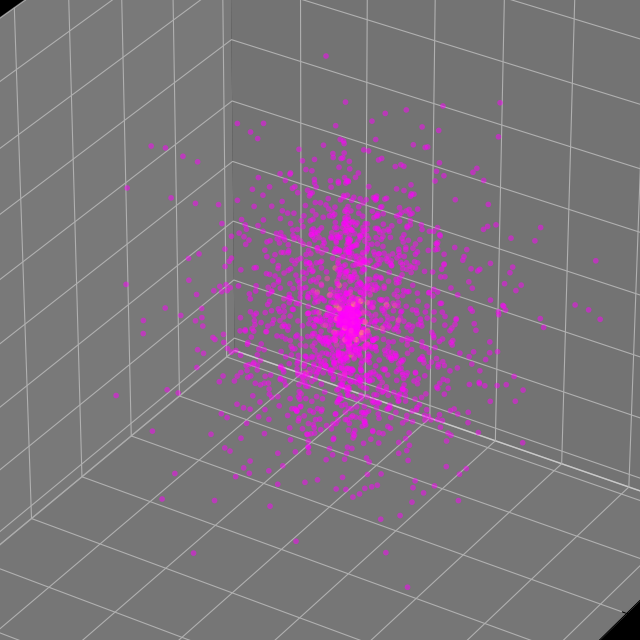

In [468]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
hibr=(input("Escriba una letra"))
if(hibr=='sp'):
    n=2
    l=0
    m=0
    n1=2
    l1=1
    m1=0
    rs=radialdots(n)
    thetas=thetadots(l,m)
    phis=phidots(l,m)
    rp=radialdots(n1)
    thetap=thetadots(l1,m1)
    phip=phidots(l1,m1)
    psis = [R_nl(n,l,rs[i]) * lpmv(abs(m),l,np.cos(thetas[i])) * p_phi(m,phis[i]) for i in range(dots)]
    psip = [R_nl(n1,l1,rp[i]) * lpmv(abs(m1),l1,np.cos(thetap[i])) * p_phi(m1,phi[i]) for i in range(dots)]
    linearcombination=[(1/np.sqrt(2)*(psis[i]+psip[i]))**2 for i in range(dots)]
    linearcombination2=[(1/np.sqrt(2)*(psis[i]-psip[i]))**2 for i in range(dots)]
    x = [((rs[i]-rp[i])**2) * np.sin((1/np.sqrt(2)*(thetas[i]-thetap[i]))**2) * np.cos((1/np.sqrt(2)*(phis[i]-phip[i]))**2) for i in range(dots)]
    y = [((rs[i]-rp[i])**2) * np.sin((1/np.sqrt(2)*(thetas[i]-thetap[i]))**2) * np.sin((1/np.sqrt(2)*(phis[i]-phip[i]))**2) for i in range(dots)]
    z = [((rs[i]-rp[i])**2) * np.cos((1/np.sqrt(2)*(thetas[i]-thetap[i]))**2) for i in range(dots)]

    x1 = [((rs[i]+rp[i])**2) * np.sin((1/np.sqrt(2)*(thetas[i]+thetap[i]))**2) * np.cos((1/np.sqrt(2)*(phis[i]+phip[i]))**2) for i in range(dots)]
    y1 = [((rs[i]+rp[i])**2) * np.sin((1/np.sqrt(2)*(thetas[i]+thetap[i]))**2) * np.sin((1/np.sqrt(2)*(phis[i]+phip[i]))**2) for i in range(dots)]
    z1 = [((rs[i]+rp[i])**2) * np.cos((1/np.sqrt(2)*(thetas[i]+thetap[i]))**2) for i in range(dots)]

    px = 1 / plt.rcParams['figure.dpi']    # Get px in inches
    fig = plt.figure(figsize = (size*px, size*px), facecolor = bgcolor)
    ax = fig.add_subplot(projection = '3d', aspect = 'equal',  facecolor = '#0000'); ax.axis('on')
    fig.subplots_adjust(top = 23/18, bottom = -29/90, left = -29/90, right = 23/18)
    ax.view_init(elev=30, azim=90)
    scat = ax.scatter(x+x1, y+y1, z+z1, c = linearcombination+linearcombination2, cmap = colormap, norm = cn(), linewidth = 0, s = defaults[11]*(72*px)**2, marker = defaults[12], alpha = defaults[13])
    #ax = fig.add_subplot(projection = '3d', aspect = 'equal', xlim = (-radial(n), radial(n)), ylim = (-radial(n), radial(n)), zlim = (-radial(n), radial(n)), facecolor = '#0000'); ax.axis('on')
    #scat = ax.scatter(x1, y1, z1, c = linearcombination, cmap = colormap, norm = cn(), linewidth = 0, s = defaults[11]*(72*px)**2, marker = defaults[12], alpha = defaults[13])
    plt.show()


In [464]:
# Plot


In [465]:
print(len(x))  # Imprimir el tamaño de x
print(len(y))  # Imprimir el tamaño de y
print(len(psi))  # Imprimir el tamaño de psi

1500
1500
1500
